In [1]:
!pip install rdkit
!pip install dgl
!pip install shap
!pip install optuna
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


In [2]:
# Uninstall existing packages
!pip uninstall -y deepchem dgl torchdata torch

# Install compatible versions
!pip install torch==1.12.0 torchdata==0.4.0 dgl==1.1.0 deepchem

# Set DGL backend to PyTorch
import os
os.environ['DGLBACKEND'] = 'pytorch'

# Verify installation
import deepchem as dc
import torch
import dgl

print("DeepChem, Torch, and DGL imports successful!")


Found existing installation: dgl 2.1.0
Uninstalling dgl-2.1.0:
  Successfully uninstalled dgl-2.1.0
Found existing installation: torchdata 0.9.0
Uninstalling torchdata-0.9.0:
  Successfully uninstalled torchdata-0.9.0
Found existing installation: torch 2.5.0+cu121
Uninstalling torch-2.5.0+cu121:
  Successfully uninstalled torch-2.5.0+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.0+cu121 requires torch==2.5.0, but you have torch 1.12.0 which is incompatible.
torchvision 0.20.0+cu121 requires torch==2.5.0, but you have torch 1.12.0 wh

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


DeepChem, Torch, and DGL imports successful!


In [3]:
from google.colab import files
file = files.upload()

Saving B3DB_regression.tsv to B3DB_regression.tsv
Saving B3DB_classification.tsv to B3DB_classification.tsv


In [ ]:
import pandas as pd

# load regression dataset
regression_data = pd.read_csv("B3DB_regression.tsv",
                              sep="\t")

# load classification dataset
classification_data = pd.read_csv("B3DB_classification.tsv",
                                  sep="\t")
print(regression_data.head())
print(classification_data.head())



   NO.                                      compound_name  \
0    1                                         moxalactam   
1    2                                      schembl614298   
2    3                             morphine-6-glucuronide   
3    4  2-[4-(5-bromo-3-methylpyridin-2-yl)butylamino]...   
4    5                                                NaN   

                                          IUPAC_name  \
0  7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...   
1  (2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...   
2  (2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-9-hydro...   
3  2-[4-(5-bromo-3-methylpyridin-2-yl)butylamino]...   
4                                                NaN   

                                              SMILES          CID  logBB  \
0  CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)(NC(=O)C(C4=CC=C...      3889.0|  -2.52   
1  CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)OC6[C@...  18595497.0|  -2.15   
2  CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@...   9847115.0|  -

**1. Classification**

In [19]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

def getMolDescriptors(mol, missingVal=None):
    ''' Calculate the full list of descriptors for a molecule '''
    descriptors = {}
    for name, func in Descriptors._descList:
        try:
            descriptors[name] = func(mol)
        except Exception as e:
            print(f"Error calculating descriptor {name}: {e}")
            descriptors[name] = missingVal
    return descriptors

# Load the classification dataset
classification_data = pd.read_csv("B3DB_classification.tsv", sep="\t")

# Drop rows with missing target labels
classification_data = classification_data.dropna(subset=['BBB+/BBB-'])

# Prepare to store descriptors
descriptor_data = []

for i, row in classification_data.iterrows():
    smiles = row['SMILES']
    mol = Chem.MolFromSmiles(smiles)

    if mol is not None:
        # Calculate descriptors for the molecule
        descriptors = getMolDescriptors(mol)
        descriptor_data.append(descriptors)
    else:
        print(f"Invalid SMILES string: {smiles}")
        descriptor_data.append({name: None for name, _ in Descriptors._descList})

# Create a DataFrame for descriptors only
descriptor_df = pd.DataFrame(descriptor_data)

# Drop rows with missing descriptors or target labels
classification_data = classification_data.reset_index(drop=True)
classification_df = pd.concat([classification_data[['BBB+/BBB-']], descriptor_df], axis=1).dropna()

# Combine descriptors with the target column, then keep only descriptor columns
classification_df = pd.concat([classification_data[['BBB+/BBB-']], descriptor_df], axis=1).dropna()
X = classification_df[descriptor_df.columns]  # Only use descriptor columns as features
y = LabelEncoder().fit_transform(classification_df['BBB+/BBB-'])
print(f"count of labels: {pd.Series(y).value_counts()}")
print(f"summary of descriptors: \n{X.describe()}")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATION WARNING: please use MorganGenerator
[07:14:02] DEPRECATI

count of labels: 0    4951
1    2851
Name: count, dtype: int64
summary of descriptors: 
       MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
count        7802.000000     7802.000000        7802.000000     7802.000000   
mean           11.648751       11.648671           0.183437       -1.065562   
std             3.063385        3.063424           0.294825        1.285377   
min             0.000000        0.000000           0.000000      -10.472222   
25%            10.940804       10.940804           0.038580       -1.602720   
50%            12.392110       12.392110           0.095475       -0.881852   
75%            13.174413       13.174413           0.210645       -0.213405   
max            17.815441       17.815441           9.847222        6.000000   

               qed          SPS        MolWt  HeavyAtomMolWt   ExactMolWt  \
count  7802.000000  7802.000000  7802.000000     7802.000000  7802.000000   
mean      0.579746    25.744136   385.658238  

In [20]:
import numpy as np

# Count the number of positive and negative infinity values in each column
inf_counts = (X == np.inf).sum().sum()
neg_inf_counts = (X == -np.inf).sum().sum()

print(f"Count of positive infinity values: {inf_counts}")
print(f"Count of negative infinity values: {neg_inf_counts}")

# Check for NaN values
nan_counts = X.isna().sum().sum()
print(f"Count of NaN values: {nan_counts}")
import numpy as np

# Check for extremely large values in each column
extreme_thresholds = X.quantile(0.999)
extreme_values = (X > extreme_thresholds).sum()

print("Count of extreme values in each column:")
print(extreme_values[extreme_values > 0])
# Cap values above the 99.9th percentile to the threshold value
for column in X.columns:
    cap_value = extreme_thresholds[column]
    X[column] = np.where(X[column] > cap_value, cap_value, X[column])

# Verify if the capping removed the issue by checking max values again
print("\nSummary after capping extreme values:")
print(X.describe().loc['max'])

Count of positive infinity values: 0
Count of negative infinity values: 0
Count of NaN values: 0
Count of extreme values in each column:
MaxAbsEStateIndex    3
MaxEStateIndex       3
MinAbsEStateIndex    7
MinEStateIndex       7
qed                  5
                    ..
fr_sulfide           8
fr_sulfone           2
fr_thiophene         7
fr_unbrch_alkane     8
fr_urea              8
Length: 183, dtype: int64

Summary after capping extreme values:


<ipython-input-20-be5307f8de14>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = np.where(X[column] > cap_value, cap_value, X[column])


MaxAbsEStateIndex    17.808922
MaxEStateIndex       17.808922
MinAbsEStateIndex     2.921682
MinEStateIndex        1.500000
qed                   0.941855
                       ...    
fr_thiazole           2.000000
fr_thiocyan           0.000000
fr_thiophene          1.000000
fr_unbrch_alkane     13.199000
fr_urea               1.199000
Name: max, Length: 210, dtype: float64


In [21]:
# Check data types and value ranges
print("Data types and max values in each column after capping:")
print(X.dtypes)
print("\nMaximum values in each column:")
print(X.max())

Data types and max values in each column after capping:
MaxAbsEStateIndex    float64
MaxEStateIndex       float64
MinAbsEStateIndex    float64
MinEStateIndex       float64
qed                  float64
                      ...   
fr_thiazole          float64
fr_thiocyan          float64
fr_thiophene         float64
fr_unbrch_alkane     float64
fr_urea              float64
Length: 210, dtype: object

Maximum values in each column:
MaxAbsEStateIndex    17.808922
MaxEStateIndex       17.808922
MinAbsEStateIndex     2.921682
MinEStateIndex        1.500000
qed                   0.941855
                       ...    
fr_thiazole           2.000000
fr_thiocyan           0.000000
fr_thiophene          1.000000
fr_unbrch_alkane     13.199000
fr_urea               1.199000
Length: 210, dtype: float64


In [22]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = clf.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Test Set Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Test Set Evaluation:
Accuracy: 0.88
Precision: 0.86
Recall: 0.81
F1 Score: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       991
           1       0.86      0.81      0.84       570

    accuracy                           0.88      1561
   macro avg       0.88      0.87      0.87      1561
weighted avg       0.88      0.88      0.88      1561



In [23]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1', verbose=3, return_train_score=True)
grid_search.fit(X_train, y_train)

# Extract and display each parameter combination with its corresponding mean test score
results_df = pd.DataFrame(grid_search.cv_results_)
display_columns = [
    'param_n_estimators', 'param_max_depth', 'param_min_samples_split',
    'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score'
]
results_df = results_df[display_columns].sort_values(by='mean_test_score', ascending=False)

print("Detailed results for each hyperparameter combination:")
print(results_df)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=(train=0.982, test=0.811) total time=   2.8s
[CV 2/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=(train=0.980, test=0.826) total time=   2.9s
[CV 3/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=(train=0.981, test=0.834) total time=   2.8s
[CV 4/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=(train=0.981, test=0.829) total time=   2.8s
[CV 5/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=(train=0.981, test=0.848) total time=   3.0s
[CV 1/5] END max_depth=None, min_samples_split=2, n_estimators=200;, score=(train=0.982, test=0.812) total time=   5.6s
[CV 2/5] END max_depth=None, min_samples_split=2, n_estimators=200;, score=(train=0.980, test=0.832) total time=   5.6s
[CV 3/5] END max_depth=None, min_samples_split=2, n_estimators=200;, score=(train=0.981, test=0.84

**2. Regression**

**2-1. Machine learning models**


: Random Forest, XGBoost, PLSRgression

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load regression dataset and drop rows with missing SMILES or target values
regression_data = pd.read_csv("B3DB_regression.tsv", sep="\t")
regression_data = regression_data.dropna(subset=['SMILES', 'logBB'])

# Function to calculate molecular descriptors
def getMolDescriptors(mol, missingVal=None):
    descriptors = {}
    for name, func in Descriptors._descList:
        try:
            descriptors[name] = func(mol)
        except Exception:
            descriptors[name] = missingVal
    return descriptors

# Prepare descriptor data
descriptor_data = []
for smiles in regression_data['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        descriptors = getMolDescriptors(mol)
        descriptor_data.append(descriptors)
    else:
        print(f"Invalid SMILES string: {smiles}")
        descriptor_data.append({name: None for name, _ in Descriptors._descList})

# Convert descriptor data to DataFrame and combine with target variable
descriptor_df = pd.DataFrame(descriptor_data)
regression_df = pd.concat([regression_data[['logBB']].reset_index(drop=True), descriptor_df], axis=1).dropna()
X = descriptor_df  # Use only descriptor columns as features
y = regression_data['logBB']  # Target variable for regression

# Check the distribution of the target variable
print(f"Summary of target variable 'logBB': \n{y.describe()}\n")


# Print summary statistics for the imputed features
print(f"Summary of descriptors:\n{X.describe()}\n")


Summary of target variable 'logBB': 
count    1058.000000
mean       -0.077873
std         0.751623
min        -2.690000
25%        -0.535000
50%        -0.020000
75%         0.420000
max         1.700000
Name: logBB, dtype: float64

Summary of descriptors:
       MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
count        1058.000000     1058.000000        1058.000000     1058.000000   
mean           10.186494       10.185903           0.317928       -0.672585   
std             3.546924        3.546929           0.528992        1.462202   
min             0.000000        0.000000           0.000000      -10.472222   
25%             8.198082        8.198082           0.062509       -0.995625   
50%            11.576130       11.576130           0.159553       -0.383909   
75%            12.710785       12.710785           0.365237        0.138878   
max            16.859063       16.859063           9.847222        6.000000   

               qed          SP

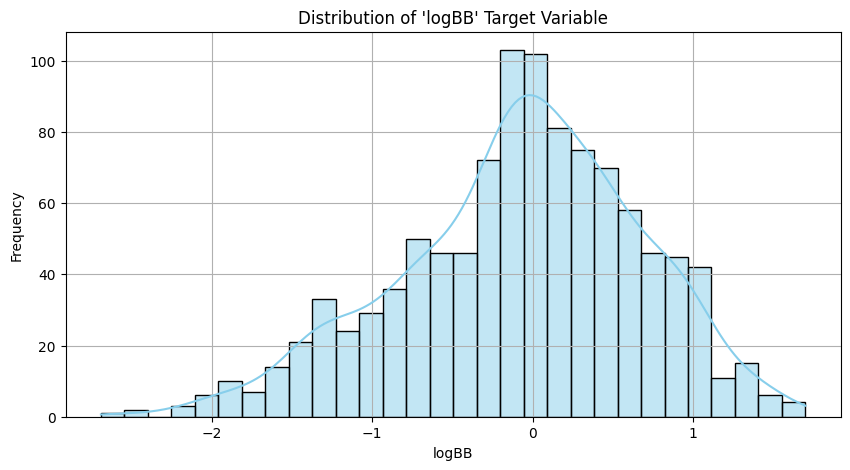

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(y, kde=True, bins=30, color='skyblue')
plt.title("Distribution of 'logBB' Target Variable")
plt.xlabel("logBB")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestRegressor with default parameters
regressor = RandomForestRegressor(random_state=42)

# Fit the model to the training data
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model's performance with MSE and R² score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RandomForestRegressor Performance :")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

RandomForestRegressor Performance :
Mean Squared Error: 0.27
R² Score: 0.53


In [ ]:

# Initialize RandomForestRegressor
regressor = RandomForestRegressor(random_state=42)

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Track progress during hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(regressor, param_grid, cv=3, scoring='r2', verbose=3, return_train_score=True)
grid_search.fit(X_train, y_train)

# Display results of each hyperparameter combination
results_df = pd.DataFrame(grid_search.cv_results_)
display_columns = [
    'param_n_estimators', 'param_max_depth', 'param_min_samples_split',
    'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score'
]
results_df = results_df[display_columns].sort_values(by='mean_test_score', ascending=False)
print("Detailed results for each hyperparameter combination:")
print(results_df)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nTest Set Evaluation:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")



Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=(train=0.938, test=0.523) total time=   7.1s
[CV 2/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=(train=0.935, test=0.678) total time=   8.2s
[CV 3/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=(train=0.942, test=0.556) total time=   4.2s
[CV 4/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=(train=0.940, test=0.590) total time=   7.3s
[CV 5/5] END max_depth=None, min_samples_split=2, n_estimators=100;, score=(train=0.939, test=0.637) total time=   4.3s
[CV 1/5] END max_depth=None, min_samples_split=2, n_estimators=200;, score=(train=0.941, test=0.526) total time=   9.2s
[CV 2/5] END max_depth=None, min_samples_split=2, n_estimators=200;, score=(train=0.937, test=0.672) total time=   8.5s
[CV 3/5] END max_depth=None, min_samples_split=2, n_estimators=200;, score=(train=0.944, test=0.55

In [ ]:

# Initialize RandomForestRegressor
regressor = RandomForestRegressor(random_state=42)

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [50, 100, 150],          # Lowered number of trees
    'max_depth': [5, 10, 15],                # Reduced depth choices
    'min_samples_split': [2, 5, 10],         # Existing parameter
    'min_samples_leaf': [5, 10, 20],         # New regularization parameter
}


# Track progress during hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(regressor, param_grid, cv=3, scoring='r2', verbose=3, return_train_score=True)
grid_search.fit(X_train, y_train)

# Display results of each hyperparameter combination
results_df = pd.DataFrame(grid_search.cv_results_)
display_columns = [
    'param_n_estimators', 'param_max_depth', 'param_min_samples_split',
    'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score'
]
results_df = results_df[display_columns].sort_values(by='mean_test_score', ascending=False)
print("Detailed results for each hyperparameter combination:")
print(results_df)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nTest Set Evaluation:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")



Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=(train=0.747, test=0.492) total time=   0.8s
[CV 2/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=(train=0.754, test=0.504) total time=   0.8s
[CV 3/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=(train=0.726, test=0.600) total time=   0.8s
[CV 1/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=(train=0.751, test=0.490) total time=   1.6s
[CV 2/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=(train=0.761, test=0.514) total time=   1.9s
[CV 3/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=(train=0.728, test=0.600) total time=   2.2s
[CV 1/3] END max_depth=5, min_samples_leaf=5, min_samples_split=2, n_estimators=150;, score=(train=0.752, test=0.493) t

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],      # Step size shrinkage
    'max_depth': [3, 5, 7],                  # Maximum depth of a tree
    'min_child_weight': [1, 3, 5],           # Minimum sum of instance weight needed in a child
    'subsample': [0.7, 0.8, 1.0],            # Fraction of samples to be used for each tree
    'colsample_bytree': [0.7, 0.8, 1.0],     # Fraction of features to be used for each tree
    'gamma': [0, 0.1, 0.3],                  # Minimum loss reduction for a split
    'reg_alpha': [0, 0.01, 0.1],             # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2]                # L2 regularization term on weights
}

# Set up the XGBoost regressor and GridSearchCV
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='r2', verbose=3, return_train_score=True)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best R² score: ", grid_search.best_score_)


Fitting 3 folds for each of 19683 candidates, totalling 59049 fits
[CV 1/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.7;, score=(train=0.338, test=0.256) total time=   0.8s
[CV 2/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.7;, score=(train=0.334, test=0.262) total time=   0.9s
[CV 3/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.7;, score=(train=0.308, test=0.293) total time=   1.4s
[CV 1/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=0.8;, score=(train=0.338, test=0.257) total time=   0.5s
[CV 2/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_es

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x789ca51cf8b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 637, in _next_wrapper
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 550, in _handle_exception
    return fn()
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/data.py", line 1416, in next
    input_data(**self.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 617, in input_data
    new, cat_codes, feature_names, feature_types = _proxy

[CV 3/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=1.0;, score=(train=0.835, test=0.593) total time=   1.9s
[CV 1/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=0.7;, score=(train=nan, test=nan) total time=   0.1s
[CV 2/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=0.7;, score=(train=0.816, test=0.522) total time=   2.5s
[CV 3/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=0.7;, score=(train=0.803, test=0.603) total time=   4.9s
[CV 1/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsampl

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the ECFP Computation Function
def compute_ecfp_fingerprints(df, radius=2, nBits=2048):
    """Compute ECFP fingerprints for molecules in the dataframe."""
    ecfp_list = []
    valid_indices = []

    for idx, smi in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue  # Skip molecules that can't be parsed
        try:
            ecfp_feats = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits))
            ecfp_list.append(ecfp_feats)
            valid_indices.append(idx)
        except Exception as e:
            print(f"Skipping molecule at index {idx} due to error: {e}")
            continue

    # Convert to DataFrame for easier manipulation
    ecfp_features = np.array(ecfp_list)
    ecfp_df = pd.DataFrame(ecfp_features, index=valid_indices)
    print(f"Shape of ECFP features: {ecfp_df.shape}")
    return ecfp_df


regression_data = pd.read_csv("B3DB_regression.tsv", sep="\t")
regression_data = regression_data.dropna(subset=['SMILES', 'logBB'])  # Drop rows with missing SMILES or target values

# Compute ECFP Fingerprints
ecfp_df = compute_ecfp_fingerprints(regression_data)  #

# Define the target variable
y = regression_data['logBB'].loc[ecfp_df.index].reset_index(drop=True)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(ecfp_df, y, test_size=0.2, random_state=42)

# Train the Simple XGBoost Model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the Model
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Shape of ECFP features: (1058, 2048)
Mean Squared Error: 0.30593707006953563
R² Score: 0.46951777870651634


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the ECFP Computation Function
def compute_ecfp_fingerprints(df, radius=2, nBits=2048):
    """Compute ECFP fingerprints for molecules in the dataframe."""
    ecfp_list = []
    valid_indices = []

    for idx, smi in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue  # Skip molecules that can't be parsed
        try:
            ecfp_feats = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits))
            ecfp_list.append(ecfp_feats)
            valid_indices.append(idx)
        except Exception as e:
            print(f"Skipping molecule at index {idx} due to error: {e}")
            continue

    # Convert to DataFrame for easier manipulation
    ecfp_features = np.array(ecfp_list)
    ecfp_df = pd.DataFrame(ecfp_features, index=valid_indices)
    print(f"Shape of ECFP features: {ecfp_df.shape}")
    return ecfp_df

regression_data = pd.read_csv("B3DB_regression.tsv", sep="\t")
regression_data = regression_data.dropna(subset=['SMILES', 'logBB'])  # Drop rows with missing SMILES or target values

# Compute ECFP Fingerprints
ecfp_df = compute_ecfp_fingerprints(regression_data)  # Pass regression_data containing 'SMILES' column

# Define the target variable
# Filter the target variable by valid indices from the ECFP computation
y = regression_data['logBB'].loc[ecfp_df.index].reset_index(drop=True)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(ecfp_df, y, test_size=0.2, random_state=42)

# Initialize RandomForestRegressor with default parameters
regressor = RandomForestRegressor(random_state=42)

# Fit the model to the training data
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model's performance with MSE and R² score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RandomForestRegressor Performance :")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Shape of ECFP features: (1058, 2048)
RandomForestRegressor Performance :
Mean Squared Error: 0.29
R² Score: 0.49


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the ECFP Computation Function
def compute_ecfp_fingerprints(df, radius=2, nBits=2048):
    """Compute ECFP fingerprints for molecules in the dataframe."""
    ecfp_list = []
    valid_indices = []

    for idx, smi in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue  # Skip molecules that can't be parsed
        try:
            ecfp_feats = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits))
            ecfp_list.append(ecfp_feats)
            valid_indices.append(idx)
        except Exception as e:
            print(f"Skipping molecule at index {idx} due to error: {e}")
            continue

    # Convert to DataFrame for easier manipulation
    ecfp_features = np.array(ecfp_list)
    ecfp_df = pd.DataFrame(ecfp_features, index=valid_indices)
    print(f"Shape of ECFP features: {ecfp_df.shape}")
    return ecfp_df

# Define the Comprehensive Descriptor Computation Function
def getMolDescriptors(mol, missingVal=None):
    """Compute all available RDKit descriptors for a molecule."""
    descriptors = {}
    for name, func in Descriptors._descList:
        try:
            descriptors[name] = func(mol)
        except Exception:
            descriptors[name] = missingVal
    return descriptors

# Compute Descriptors for Each Molecule
def compute_all_descriptors(df):
    """Compute descriptors for all molecules in the dataframe."""
    descriptor_data = []
    valid_indices = []

    for idx, smiles in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            descriptors = getMolDescriptors(mol)
            descriptor_data.append(descriptors)
            valid_indices.append(idx)
        else:
            print(f"Invalid SMILES string at index {idx}: {smiles}")
            descriptor_data.append({name: None for name, _ in Descriptors._descList})  # Fill with missing values for invalid SMILES

    descriptor_df = pd.DataFrame(descriptor_data, index=valid_indices)
    print(f"Shape of Descriptor features: {descriptor_df.shape}")
    return descriptor_df

regression_data = pd.read_csv("B3DB_regression.tsv", sep="\t")
regression_data = regression_data.dropna(subset=['SMILES', 'logBB'])  # Drop rows with missing SMILES or target values

# Compute ECFP Fingerprints and Descriptors
ecfp_df = compute_ecfp_fingerprints(regression_data)       # ECFP features
descriptor_df = compute_all_descriptors(regression_data)   # All RDKit descriptors

valid_indices = ecfp_df.index.intersection(descriptor_df.index)
X_combined = pd.concat([ecfp_df.loc[valid_indices].reset_index(drop=True),
                        descriptor_df.loc[valid_indices].reset_index(drop=True)], axis=1)

# Define the target variable, filtered by valid indices
y = regression_data['logBB'].loc[valid_indices].reset_index(drop=True)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train the Simple XGBoost Model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the Model
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Shape of ECFP features: (1058, 2048)
Shape of Descriptor features: (1058, 210)
Mean Squared Error: 0.31869099120046307
R² Score: 0.44740300716151016


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the ECFP Computation Function
def compute_ecfp_fingerprints(df, radius=2, nBits=2048):
    """Compute ECFP fingerprints for molecules in the dataframe."""
    ecfp_list = []
    valid_indices = []

    for idx, smi in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue  # Skip molecules that can't be parsed
        try:
            ecfp_feats = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits))
            ecfp_list.append(ecfp_feats)
            valid_indices.append(idx)
        except Exception as e:
            print(f"Skipping molecule at index {idx} due to error: {e}")
            continue

    # Convert to DataFrame for easier manipulation
    ecfp_features = np.array(ecfp_list)
    ecfp_df = pd.DataFrame(ecfp_features, index=valid_indices)
    print(f"Shape of ECFP features: {ecfp_df.shape}")
    return ecfp_df

# Define the Comprehensive Descriptor Computation Function
def getMolDescriptors(mol, missingVal=None):
    """Compute all available RDKit descriptors for a molecule."""
    descriptors = {}
    for name, func in Descriptors._descList:
        try:
            descriptors[name] = func(mol)
        except Exception:
            descriptors[name] = missingVal
    return descriptors

# Compute Descriptors for Each Molecule
def compute_all_descriptors(df):
    """Compute descriptors for all molecules in the dataframe."""
    descriptor_data = []
    valid_indices = []

    for idx, smiles in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            descriptors = getMolDescriptors(mol)
            descriptor_data.append(descriptors)
            valid_indices.append(idx)
        else:
            print(f"Invalid SMILES string at index {idx}: {smiles}")
            descriptor_data.append({name: None for name, _ in Descriptors._descList})  # Fill with missing values for invalid SMILES

    descriptor_df = pd.DataFrame(descriptor_data, index=valid_indices)
    print(f"Shape of Descriptor features: {descriptor_df.shape}")
    return descriptor_df

regression_data = pd.read_csv("B3DB_regression.tsv", sep="\t")
regression_data = regression_data.dropna(subset=['SMILES', 'logBB'])  # Drop rows with missing SMILES or target values

# Compute ECFP Fingerprints and Descriptors
ecfp_df = compute_ecfp_fingerprints(regression_data)       # ECFP features
descriptor_df = compute_all_descriptors(regression_data)   # All RDKit descriptors

# Filter and Combine Features
# Ensure we only keep rows with valid SMILES that have both ECFP and descriptor data
valid_indices = ecfp_df.index.intersection(descriptor_df.index)
X_combined = pd.concat([ecfp_df.loc[valid_indices].reset_index(drop=True),
                        descriptor_df.loc[valid_indices].reset_index(drop=True)], axis=1)

# Define the target variable, filtered by valid indices
y = regression_data['logBB'].loc[valid_indices].reset_index(drop=True)
# Ensure all column names are strings in the combined feature set
X_combined.columns = X_combined.columns.astype(str)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# initialize RandomForestRegressor with default parameters
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(random_state=42)

# Fit the model to the training data
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model's performance with MSE and R² score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RandomForestRegressor Performance :")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")



Shape of ECFP features: (1058, 2048)
Shape of Descriptor features: (1058, 210)
RandomForestRegressor Performance :
Mean Squared Error: 0.27
R² Score: 0.52


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna

# Define the ECFP Computation Function
def compute_ecfp_fingerprints(df, radius=2, nBits=2048):
    ecfp_list = []
    valid_indices = []
    for idx, smi in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue
        try:
            ecfp_feats = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits))
            ecfp_list.append(ecfp_feats)
            valid_indices.append(idx)
        except Exception as e:
            print(f"Skipping molecule at index {idx} due to error: {e}")
            continue
    ecfp_df = pd.DataFrame(ecfp_list, index=valid_indices)
    print(f"Shape of ECFP features: {ecfp_df.shape}")
    return ecfp_df

# Define the Descriptor Computation Function
def getMolDescriptors(mol, missingVal=None):
    descriptors = {}
    for name, func in Descriptors._descList:
        try:
            descriptors[name] = func(mol)
        except Exception:
            descriptors[name] = missingVal
    return descriptors

# Compute Descriptors for Each Molecule
def compute_all_descriptors(df):
    descriptor_data = []
    valid_indices = []
    for idx, smiles in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            descriptors = getMolDescriptors(mol)
            descriptor_data.append(descriptors)
            valid_indices.append(idx)
        else:
            print(f"Invalid SMILES string at index {idx}: {smiles}")
            descriptor_data.append({name: None for name, _ in Descriptors._descList})
    descriptor_df = pd.DataFrame(descriptor_data, index=valid_indices)
    print(f"Shape of Descriptor features: {descriptor_df.shape}")
    return descriptor_df

# Load your data
regression_data = pd.read_csv("B3DB_regression.tsv", sep="\t")
regression_data = regression_data.dropna(subset=['SMILES', 'logBB'])

# Compute ECFP Fingerprints and Descriptors
ecfp_df = compute_ecfp_fingerprints(regression_data)
descriptor_df = compute_all_descriptors(regression_data)

# Combine Features and Define Target Variable
valid_indices = ecfp_df.index.intersection(descriptor_df.index)
X_combined = pd.concat([ecfp_df.loc[valid_indices].reset_index(drop=True),
                        descriptor_df.loc[valid_indices].reset_index(drop=True)], axis=1)
X_combined.columns = X_combined.columns.astype(str)
y = regression_data['logBB'].loc[valid_indices].reset_index(drop=True)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Define Objective Function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', [ 'sqrt', 'log2'])

    # Create the model with the suggested hyperparameters
    regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Fit the model
    regressor.fit(X_train, y_train)

    # Predict and calculate R² score on validation data
    y_pred = regressor.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Output Top 10 Hyperparameters and Scores
print("\nTop 10 Hyperparameter Configurations:")
top_10_trials = sorted(study.trials, key=lambda x: x.value, reverse=True)[:10]
for i, trial in enumerate(top_10_trials, 1):
    print(f"\nTrial {i}")
    print(f"Score (R²): {trial.value:.4f}")
    print("Hyperparameters:", trial.params)

# Train final model with the best parameters
best_params = study.best_params
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate on Test Set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nFinal Model Performance on Test Set:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Shape of ECFP features: (1058, 2048)


[I 2024-10-27 03:48:09,754] A new study created in memory with name: no-name-ed028111-b247-4863-a2cf-782b54b80537


Shape of Descriptor features: (1058, 210)


[I 2024-10-27 03:48:10,549] Trial 0 finished with value: 0.3403529849939686 and parameters: {'n_estimators': 488, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.3403529849939686.
[I 2024-10-27 03:48:11,328] Trial 1 finished with value: 0.3808212545462639 and parameters: {'n_estimators': 341, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.3808212545462639.
[I 2024-10-27 03:48:11,823] Trial 2 finished with value: 0.42957992094194986 and parameters: {'n_estimators': 251, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.42957992094194986.
[I 2024-10-27 03:48:13,880] Trial 3 finished with value: 0.5380648697411954 and parameters: {'n_estimators': 494, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.5380648697411


Top 10 Hyperparameter Configurations:

Trial 1
Score (R²): 0.5577
Hyperparameters: {'n_estimators': 110, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Trial 2
Score (R²): 0.5577
Hyperparameters: {'n_estimators': 319, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Trial 3
Score (R²): 0.5576
Hyperparameters: {'n_estimators': 123, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Trial 4
Score (R²): 0.5576
Hyperparameters: {'n_estimators': 112, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Trial 5
Score (R²): 0.5575
Hyperparameters: {'n_estimators': 124, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Trial 6
Score (R²): 0.5575
Hyperparameters: {'n_estimators': 124, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Trial 7
Score (R²): 0.5574
Hyp

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna

# Define the ECFP Computation Function
def compute_ecfp_fingerprints(df, radius=2, nBits=2048):
    ecfp_list = []
    valid_indices = []
    for idx, smi in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue
        try:
            ecfp_feats = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits))
            ecfp_list.append(ecfp_feats)
            valid_indices.append(idx)
        except Exception as e:
            print(f"Skipping molecule at index {idx} due to error: {e}")
            continue
    ecfp_df = pd.DataFrame(ecfp_list, index=valid_indices)
    print(f"Shape of ECFP features: {ecfp_df.shape}")
    return ecfp_df

#  Define the Descriptor Computation Function
def getMolDescriptors(mol, missingVal=None):
    descriptors = {}
    for name, func in Descriptors._descList:
        try:
            descriptors[name] = func(mol)
        except Exception:
            descriptors[name] = missingVal
    return descriptors

# Compute Descriptors for Each Molecule
def compute_all_descriptors(df):
    descriptor_data = []
    valid_indices = []
    for idx, smiles in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            descriptors = getMolDescriptors(mol)
            descriptor_data.append(descriptors)
            valid_indices.append(idx)
        else:
            print(f"Invalid SMILES string at index {idx}: {smiles}")
            descriptor_data.append({name: None for name, _ in Descriptors._descList})
    descriptor_df = pd.DataFrame(descriptor_data, index=valid_indices)
    print(f"Shape of Descriptor features: {descriptor_df.shape}")
    return descriptor_df

# Load your data
regression_data = pd.read_csv("B3DB_regression.tsv", sep="\t")
regression_data = regression_data.dropna(subset=['SMILES', 'logBB'])

# Compute ECFP Fingerprints and Descriptors
ecfp_df = compute_ecfp_fingerprints(regression_data)
descriptor_df = compute_all_descriptors(regression_data)

# Combine Features and Define Target Variable
valid_indices = ecfp_df.index.intersection(descriptor_df.index)
X_combined = pd.concat([ecfp_df.loc[valid_indices].reset_index(drop=True),
                        descriptor_df.loc[valid_indices].reset_index(drop=True)], axis=1)
X_combined.columns = X_combined.columns.astype(str)
y = regression_data['logBB'].loc[valid_indices].reset_index(drop=True)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Define Objective Function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', [ 'sqrt', 'log2'])

    # Create the model with the suggested hyperparameters
    regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Fit the model
    regressor.fit(X_train, y_train)

    # Predict and calculate R² score on validation data
    y_pred = regressor.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

#  Output Top 10 Hyperparameters and Scores
print("\nTop 10 Hyperparameter Configurations:")
top_10_trials = sorted(study.trials, key=lambda x: x.value, reverse=True)[:10]
for i, trial in enumerate(top_10_trials, 1):
    print(f"\nTrial {i}")
    print(f"Score (R²): {trial.value:.4f}")
    print("Hyperparameters:", trial.params)

# Train final model with the best parameters
best_params = study.best_params
best_model = RandomForestRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate on Test Set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nFinal Model Performance on Test Set:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Shape of ECFP features: (1058, 2048)


[I 2024-10-27 03:51:54,904] A new study created in memory with name: no-name-310e0bbc-572b-4aa8-af3b-8ff5a725c5ff


Shape of Descriptor features: (1058, 210)


[I 2024-10-27 03:51:55,461] Trial 0 finished with value: 0.5317574784511014 and parameters: {'n_estimators': 119, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5317574784511014.
[I 2024-10-27 03:51:55,969] Trial 1 finished with value: 0.5302288603789113 and parameters: {'n_estimators': 116, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5317574784511014.
[I 2024-10-27 03:51:56,606] Trial 2 finished with value: 0.5363223470086405 and parameters: {'n_estimators': 110, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5363223470086405.
[I 2024-10-27 03:51:57,224] Trial 3 finished with value: 0.5338014033762388 and parameters: {'n_estimators': 107, 'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.53632234700864


Top 10 Hyperparameter Configurations:

Trial 1
Score (R²): 0.5587
Hyperparameters: {'n_estimators': 109, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Trial 2
Score (R²): 0.5587
Hyperparameters: {'n_estimators': 109, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Trial 3
Score (R²): 0.5587
Hyperparameters: {'n_estimators': 109, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Trial 4
Score (R²): 0.5587
Hyperparameters: {'n_estimators': 109, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Trial 5
Score (R²): 0.5587
Hyperparameters: {'n_estimators': 109, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Trial 6
Score (R²): 0.5587
Hyperparameters: {'n_estimators': 109, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

Trial 7
Score (R²): 0.5587
Hyp

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Define the ECFP Computation Function
def compute_ecfp_fingerprints(df, radius=2, nBits=2048):
    ecfp_list = []
    valid_indices = []
    for idx, smi in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue
        try:
            ecfp_feats = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits))
            ecfp_list.append(ecfp_feats)
            valid_indices.append(idx)
        except Exception as e:
            print(f"Skipping molecule at index {idx} due to error: {e}")
            continue
    ecfp_df = pd.DataFrame(ecfp_list, index=valid_indices)
    print(f"Shape of ECFP features: {ecfp_df.shape}")
    return ecfp_df

# Define the Descriptor Computation Function
def getMolDescriptors(mol, missingVal=None):
    descriptors = {}
    for name, func in Descriptors._descList:
        try:
            descriptors[name] = func(mol)
        except Exception:
            descriptors[name] = missingVal
    return descriptors

# Compute Descriptors for Each Molecule
def compute_all_descriptors(df):
    descriptor_data = []
    valid_indices = []
    for idx, smiles in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            descriptors = getMolDescriptors(mol)
            descriptor_data.append(descriptors)
            valid_indices.append(idx)
        else:
            print(f"Invalid SMILES string at index {idx}: {smiles}")
            descriptor_data.append({name: None for name, _ in Descriptors._descList})
    descriptor_df = pd.DataFrame(descriptor_data, index=valid_indices)
    print(f"Shape of Descriptor features: {descriptor_df.shape}")
    return descriptor_df

# Load your data
regression_data = pd.read_csv("B3DB_regression.tsv", sep="\t")
regression_data = regression_data.dropna(subset=['SMILES', 'logBB'])

# Compute ECFP Fingerprints and Descriptors
ecfp_df = compute_ecfp_fingerprints(regression_data)
descriptor_df = compute_all_descriptors(regression_data)

# Combine Features and Define Target Variable
valid_indices = ecfp_df.index.intersection(descriptor_df.index)
X_combined = pd.concat([ecfp_df.loc[valid_indices].reset_index(drop=True),
                        descriptor_df.loc[valid_indices].reset_index(drop=True)], axis=1)

# Drop rows with any NaN values in `X_combined`
X_combined = X_combined.dropna()
y = regression_data['logBB'].loc[valid_indices].reset_index(drop=True)
y = y[X_combined.index]  # Align `y` with `X_combined`

# Check for extremely large values in each column
extreme_thresholds = X_combined.quantile(0.999)
for column in X_combined.columns:
    cap_value = extreme_thresholds[column]
    X_combined[column] = np.where(X_combined[column] > cap_value, cap_value, X_combined[column])

# Convert column names to strings to avoid issues with mixed types
X_combined.columns = X_combined.columns.astype(str)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Initialize and Train the PLS Model
n_components = 3  # Adjust the number of components if needed
pls_model = PLSRegression(n_components=n_components)
pls_model.fit(X_train, y_train)

# Make Predictions and Evaluate the Model
y_pred = pls_model.predict(X_test)
r_squared = pls_model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

print(f"R-Squared: {r_squared}")
print(f"Mean Squared Error: {mse}")


Shape of ECFP features: (1058, 2048)
Shape of Descriptor features: (1058, 210)
R-Squared: 0.586363944161495
Mean Squared Error: 0.22509164960276232


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression

# Define the range of components to evaluate
n_components_range = range(1, 20)  # Adjust upper limit based on dataset size
best_score = -np.inf
best_n_components = None

# Evaluate each number of components using cross-validation
for n in n_components_range:
    pls_model = PLSRegression(n_components=n, scale=True)
    scores = cross_val_score(pls_model, X_train, y_train, cv=5, scoring='r2')
    mean_score = scores.mean()
    print(f"Number of Components: {n}, Cross-validated R² Score: {mean_score:.4f}")

    if mean_score > best_score:
        best_score = mean_score
        best_n_components = n

print(f"Best n_components: {best_n_components}")
print(f"Cross-validated R² Score: {best_score:.4f}")


Number of Components: 1, Cross-validated R² Score: 0.1437
Number of Components: 2, Cross-validated R² Score: 0.4554
Number of Components: 3, Cross-validated R² Score: 0.4507
Number of Components: 4, Cross-validated R² Score: 0.4052
Number of Components: 5, Cross-validated R² Score: 0.4038
Number of Components: 6, Cross-validated R² Score: 0.3439
Number of Components: 7, Cross-validated R² Score: 0.3217
Number of Components: 8, Cross-validated R² Score: 0.0934
Number of Components: 9, Cross-validated R² Score: -0.0870
Number of Components: 10, Cross-validated R² Score: -0.4572
Number of Components: 11, Cross-validated R² Score: -1.1854
Number of Components: 12, Cross-validated R² Score: -1.8682
Number of Components: 13, Cross-validated R² Score: -2.8282
Number of Components: 14, Cross-validated R² Score: -3.9219
Number of Components: 15, Cross-validated R² Score: -4.9011
Number of Components: 16, Cross-validated R² Score: -6.0613
Number of Components: 17, Cross-validated R² Score: -6.93

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#  Define the ECFP Computation Function
def compute_ecfp_fingerprints(df, radius=2, nBits=2048):
    ecfp_list = []
    valid_indices = []
    for idx, smi in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue
        try:
            ecfp_feats = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits))
            ecfp_list.append(ecfp_feats)
            valid_indices.append(idx)
        except Exception as e:
            print(f"Skipping molecule at index {idx} due to error: {e}")
            continue
    ecfp_df = pd.DataFrame(ecfp_list, index=valid_indices)
    print(f"Shape of ECFP features: {ecfp_df.shape}")
    return ecfp_df

#  Define the Descriptor Computation Function
def getMolDescriptors(mol, missingVal=None):
    descriptors = {}
    for name, func in Descriptors._descList:
        try:
            descriptors[name] = func(mol)
        except Exception:
            descriptors[name] = missingVal
    return descriptors

# Compute Descriptors for Each Molecule
def compute_all_descriptors(df):
    descriptor_data = []
    valid_indices = []
    for idx, smiles in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            descriptors = getMolDescriptors(mol)
            descriptor_data.append(descriptors)
            valid_indices.append(idx)
        else:
            print(f"Invalid SMILES string at index {idx}: {smiles}")
            descriptor_data.append({name: None for name, _ in Descriptors._descList})
    descriptor_df = pd.DataFrame(descriptor_data, index=valid_indices)
    print(f"Shape of Descriptor features: {descriptor_df.shape}")
    return descriptor_df

# Load your data
regression_data = pd.read_csv("B3DB_regression.tsv", sep="\t")
regression_data = regression_data.dropna(subset=['SMILES', 'logBB'])

#Compute ECFP Fingerprints and Descriptors
ecfp_df = compute_ecfp_fingerprints(regression_data)
descriptor_df = compute_all_descriptors(regression_data)

# Combine Features and Define Target Variable
valid_indices = ecfp_df.index.intersection(descriptor_df.index)
X_combined = pd.concat([ecfp_df.loc[valid_indices].reset_index(drop=True),
                        descriptor_df.loc[valid_indices].reset_index(drop=True)], axis=1)

# Drop rows with any NaN values in `X_combined`
X_combined = X_combined.dropna()
y = regression_data['logBB'].loc[valid_indices].reset_index(drop=True)
y = y[X_combined.index]  # Align `y` with `X_combined`

# Check for extremely large values in each column
extreme_thresholds = X_combined.quantile(0.999)
for column in X_combined.columns:
    cap_value = extreme_thresholds[column]
    X_combined[column] = np.where(X_combined[column] > cap_value, cap_value, X_combined[column])

# Convert column names to strings to avoid issues with mixed types
X_combined.columns = X_combined.columns.astype(str)

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Initialize and Train the PLS Model
n_components = 2  # Adjust the number of components if needed
pls_model = PLSRegression(n_components=n_components)
pls_model.fit(X_train, y_train)

# Make Predictions and Evaluate the Model
y_pred = pls_model.predict(X_test)
r_squared = pls_model.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

print(f"R-Squared: {r_squared}")
print(f"Mean Squared Error: {mse}")


Shape of ECFP features: (1058, 2048)
Shape of Descriptor features: (1058, 210)
R-Squared: 0.5258665637246713
Mean Squared Error: 0.2580129942654412


**2-2. MLP**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.preprocessing import MinMaxScaler

def compute_ecfp_fingerprints(df, radius=2, nBits=2048):
    ecfp_list = []
    valid_indices = []
    for idx, smi in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            continue
        ecfp_feats = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits))
        ecfp_list.append(ecfp_feats)
        valid_indices.append(idx)
    ecfp_df = pd.DataFrame(ecfp_list, index=valid_indices)
    return ecfp_df

def getMolDescriptors(mol, missingVal=None):
    descriptors = {}
    for name, func in Descriptors._descList:
        try:
            descriptors[name] = func(mol)
        except Exception:
            descriptors[name] = missingVal
    return descriptors

def compute_all_descriptors(df):
    descriptor_data = []
    valid_indices = []
    for idx, smiles in df['SMILES'].items():
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            descriptors = getMolDescriptors(mol)
            descriptor_data.append(descriptors)
            valid_indices.append(idx)
    descriptor_df = pd.DataFrame(descriptor_data, index=valid_indices)
    return descriptor_df

# Load the data
regression_data = pd.read_csv("B3DB_regression.tsv", sep="\t").dropna(subset=['SMILES', 'logBB'])

# Compute ECFP fingerprints and descriptors
ecfp_df = compute_ecfp_fingerprints(regression_data)
descriptor_df = compute_all_descriptors(regression_data)
valid_indices = ecfp_df.index.intersection(descriptor_df.index)
# Split ECFP and descriptor data
ecfp_features = ecfp_df.loc[valid_indices].reset_index(drop=True)
descriptor_features = descriptor_df.loc[valid_indices].reset_index(drop=True)

# Apply MinMax scaling to descriptor features only
scaler = MinMaxScaler()
scaled_descriptor_features = scaler.fit_transform(descriptor_features.fillna(0))  # Handling any NaN values

# Combine scaled descriptors and unscaled ECFP features
X_combined = np.hstack([ecfp_features.values, scaled_descriptor_features])
y = regression_data['logBB'].loc[valid_indices].reset_index(drop=True)

# Convert combined data to tensors for PyTorch
X = torch.tensor(X_combined, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)

# Define model
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, 1)  # Output layer for regression

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Model setup
input_dim = X.shape[1]
model = SimpleMLP(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Data loading
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
validation_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Training setup
loss_module = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100  # Number of epochs for training

# Training function with validation tracking
def train_model(model, optimizer, train_loader, validation_loader, loss_module, num_epochs=100):
    model.train()
    train_loss_list = []
    validation_loss_list = []

    for epoch in tqdm(range(num_epochs)):
        # Training phase
        model.train()
        train_loss = 0.0
        for data_inputs, data_labels in train_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

            # Forward pass
            preds = model(data_inputs).squeeze()
            loss = loss_module(preds, data_labels)
            train_loss += loss.item()  # Accumulate training loss

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data_inputs, data_labels in validation_loader:
                data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

                # Forward pass
                preds = model(data_inputs).squeeze()
                loss = loss_module(preds, data_labels)
                val_loss += loss.item()  # Accumulate validation loss

        val_loss /= len(validation_loader)
        validation_loss_list.append(val_loss)

        # Print progress
        if epoch % 5 == 0:
            print(f"Epoch: {epoch+1:03d}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return train_loss_list, validation_loss_list

# Training and validation
train_loss_list, validation_loss_list = train_model(
    model, optimizer, train_loader, validation_loader, loss_module, num_epochs=num_epochs
)

# Final evaluation on test data
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).squeeze()
    test_loss = loss_module(test_preds, y_test.to(device)).item()
    r2 = r2_score(y_test.cpu().numpy(), test_preds.cpu().numpy())

print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test R² Score: {r2:.4f}")



  2%|▏         | 2/100 [00:00<00:05, 16.56it/s]

Epoch: 001/100, Training Loss: 0.4725, Validation Loss: 0.3561


  8%|▊         | 8/100 [00:00<00:05, 15.55it/s]

Epoch: 006/100, Training Loss: 0.0504, Validation Loss: 0.3102


 14%|█▍        | 14/100 [00:00<00:05, 15.93it/s]

Epoch: 011/100, Training Loss: 0.0164, Validation Loss: 0.3154


 18%|█▊        | 18/100 [00:01<00:05, 16.33it/s]

Epoch: 016/100, Training Loss: 0.0119, Validation Loss: 0.3226


 24%|██▍       | 24/100 [00:01<00:04, 16.06it/s]

Epoch: 021/100, Training Loss: 0.0084, Validation Loss: 0.3226


 28%|██▊       | 28/100 [00:01<00:04, 16.17it/s]

Epoch: 026/100, Training Loss: 0.0070, Validation Loss: 0.3212


 34%|███▍      | 34/100 [00:02<00:04, 16.48it/s]

Epoch: 031/100, Training Loss: 0.0080, Validation Loss: 0.3211


 38%|███▊      | 38/100 [00:02<00:03, 16.45it/s]

Epoch: 036/100, Training Loss: 0.0060, Validation Loss: 0.3104


 44%|████▍     | 44/100 [00:02<00:03, 16.16it/s]

Epoch: 041/100, Training Loss: 0.0071, Validation Loss: 0.3147


 48%|████▊     | 48/100 [00:02<00:03, 16.43it/s]

Epoch: 046/100, Training Loss: 0.0068, Validation Loss: 0.3212


 52%|█████▏    | 52/100 [00:03<00:03, 15.14it/s]

Epoch: 051/100, Training Loss: 0.0077, Validation Loss: 0.3182


 58%|█████▊    | 58/100 [00:03<00:03, 13.53it/s]

Epoch: 056/100, Training Loss: 0.0055, Validation Loss: 0.3111


 62%|██████▏   | 62/100 [00:04<00:02, 13.56it/s]

Epoch: 061/100, Training Loss: 0.0051, Validation Loss: 0.3120


 68%|██████▊   | 68/100 [00:04<00:02, 13.24it/s]

Epoch: 066/100, Training Loss: 0.0052, Validation Loss: 0.3156


 72%|███████▏  | 72/100 [00:04<00:02, 12.37it/s]

Epoch: 071/100, Training Loss: 0.0052, Validation Loss: 0.3159


 78%|███████▊  | 78/100 [00:05<00:01, 12.52it/s]

Epoch: 076/100, Training Loss: 0.0045, Validation Loss: 0.3166


 82%|████████▏ | 82/100 [00:05<00:02,  8.60it/s]

Epoch: 081/100, Training Loss: 0.0055, Validation Loss: 0.3151


 88%|████████▊ | 88/100 [00:06<00:00, 12.11it/s]

Epoch: 086/100, Training Loss: 0.0053, Validation Loss: 0.3130


 94%|█████████▍| 94/100 [00:06<00:00, 14.32it/s]

Epoch: 091/100, Training Loss: 0.0056, Validation Loss: 0.3103


 98%|█████████▊| 98/100 [00:06<00:00, 15.00it/s]

Epoch: 096/100, Training Loss: 0.0061, Validation Loss: 0.3079


100%|██████████| 100/100 [00:07<00:00, 14.19it/s]

Test Loss (MSE): 0.2987
Test R² Score: 0.4821


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import optuna

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        super(MLP, self).__init__()
        layers = []

        # First hidden layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        # Output layer
        layers.append(nn.Linear(hidden_dim, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256, 512])
    num_layers = trial.suggest_int("num_layers",  1, 3)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)  # Updated syntax
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Create data loaders
    train_data, valid_data, train_targets, valid_targets = train_test_split(X, y, test_size=0.2, random_state=42)
    train_loader = DataLoader(TensorDataset(train_data, train_targets), batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(TensorDataset(valid_data, valid_targets), batch_size=batch_size, shuffle=False)

    # Initialize the model, loss, and optimizer
    input_dim = X.shape[1]
    model = MLP(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, dropout_rate=dropout_rate).to(device)
    loss_module = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    num_epochs = 100
    best_valid_loss = float("inf")
    best_r2 = -float("inf")
    patience, patience_counter = 10, 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for data_inputs, data_labels in train_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

            optimizer.zero_grad()
            preds = model(data_inputs).squeeze()
            loss = loss_module(preds, data_labels.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation step
        model.eval()
        valid_loss = 0.0
        preds_list, labels_list = [], []
        with torch.no_grad():
            for data_inputs, data_labels in valid_loader:
                data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
                preds = model(data_inputs).squeeze()
                preds_list.extend(preds.cpu().numpy())
                labels_list.extend(data_labels.cpu().numpy())
                loss = loss_module(preds, data_labels.float())
                valid_loss += loss.item()

        # Calculate R² for validation
        valid_loss /= len(valid_loader)
        preds_array, labels_array = np.array(preds_list), np.array(labels_list)
        valid_r2 = r2_score(labels_array, preds_array)

        # Early stopping
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_r2 = valid_r2
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    trial.set_user_attr("valid_r2", best_r2)
    return best_valid_loss

# Set up and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Print the best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value (Loss): {trial.value}")
print(f"  Params: {trial.params}")
print(f"  Validation R²: {trial.user_attrs['valid_r2']}")

# Output top 10 trials
print("\nTop 10 trials:")
top_10_trials = sorted(study.trials, key=lambda x: x.value)[:10]
for i, t in enumerate(top_10_trials, 1):
    print(f"Trial {i} - Loss: {t.value:.4f}, Params: {t.params}, Validation R²: {t.user_attrs['valid_r2']:.4f}")


[I 2024-10-27 04:39:12,256] A new study created in memory with name: no-name-87bd65bf-eff3-4559-ad39-00721dcde875
[I 2024-10-27 04:39:13,809] Trial 0 finished with value: 0.310543667525053 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_rate': 0.33882396260247816, 'learning_rate': 0.0015629395679993782, 'batch_size': 64}. Best is trial 0 with value: 0.310543667525053.
[I 2024-10-27 04:39:16,590] Trial 1 finished with value: 0.29004940603460583 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout_rate': 0.4624977170540201, 'learning_rate': 0.007473227776834686, 'batch_size': 32}. Best is trial 1 with value: 0.29004940603460583.
[I 2024-10-27 04:39:21,900] Trial 2 finished with value: 0.2723926209977695 and parameters: {'hidden_dim': 512, 'num_layers': 1, 'dropout_rate': 0.3157666146072594, 'learning_rate': 0.00013176690290753003, 'batch_size': 16}. Best is trial 2 with value: 0.2723926209977695.
[I 2024-10-27 04:39:23,237] Trial 3 finished with value: 0.2815992832

Best trial:
  Value (Loss): 0.24743948663984025
  Params: {'hidden_dim': 512, 'num_layers': 3, 'dropout_rate': 0.348829473628014, 'learning_rate': 0.0001612887827749467, 'batch_size': 16}
  Validation R²: 0.5762923955917358

Top 10 trials:
Trial 1 - Loss: 0.2474, Params: {'hidden_dim': 512, 'num_layers': 3, 'dropout_rate': 0.348829473628014, 'learning_rate': 0.0001612887827749467, 'batch_size': 16}, Validation R²: 0.5763
Trial 2 - Loss: 0.2492, Params: {'hidden_dim': 512, 'num_layers': 3, 'dropout_rate': 0.48039852572629405, 'learning_rate': 0.0003868468783532605, 'batch_size': 16}, Validation R²: 0.5718
Trial 3 - Loss: 0.2549, Params: {'hidden_dim': 512, 'num_layers': 2, 'dropout_rate': 0.33505494020182836, 'learning_rate': 0.00028301015452717544, 'batch_size': 16}, Validation R²: 0.5666
Trial 4 - Loss: 0.2557, Params: {'hidden_dim': 512, 'num_layers': 3, 'dropout_rate': 0.48791822334002816, 'learning_rate': 0.00017779524995228341, 'batch_size': 16}, Validation R²: 0.5639
Trial 5 - Lo

**2-3. GNN**

In [5]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.3 MB/s eta 0:00:00


In [6]:
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.data import Data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from rdkit import Chem
import pandas as pd
from tqdm import tqdm
# Initialize valid_atoms as an empty dictionary to dynamically add atoms as they are encountered
# Set the fixed length for node attributes
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm

FIXED_NODE_ATTR_LENGTH = 30
valid_atoms = {'H': 0, 'B': 1, 'C': 2, 'N': 3, 'O': 4, 'F': 5, 'P': 6, 'S': 7, 'Cl': 8}

def convert_mol_to_graph(mol, use_pos=False):
    mol2 = Chem.RemoveHs(mol)
    n_bonds = len(mol2.GetBonds())
    n_atoms = len(mol2.GetAtoms())

    edge_index_list = []
    edge_attr_list = []
    edge_weight_list = []

    # Edge attribute and weight calculation
    for edge_idx in range(n_bonds):
        bond = mol2.GetBondWithIdx(edge_idx)
        begin_idx, end_idx = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index_list.extend([[begin_idx, end_idx], [end_idx, begin_idx]])

        bond_type_map = {
            Chem.rdchem.BondType.SINGLE: [1, 0, 0, 0],
            Chem.rdchem.BondType.AROMATIC: [0, 1, 0, 0],
            Chem.rdchem.BondType.DOUBLE: [0, 0, 1, 0],
            Chem.rdchem.BondType.TRIPLE: [0, 0, 0, 1]
        }
        bond_one_hot = bond_type_map.get(bond.GetBondType(), [0, 0, 0, 0])
        edge_weight_list.extend([1.0, 1.0])  # Adjusted default weights

        stereo_map = {
            Chem.rdchem.BondStereo.STEREOANY: [1, 0, 0, 0, 0, 0],
            Chem.rdchem.BondStereo.STEREOCIS: [0, 1, 0, 0, 0, 0],
            Chem.rdchem.BondStereo.STEREOE: [0, 0, 1, 0, 0, 0],
            Chem.rdchem.BondStereo.STEREONONE: [0, 0, 0, 1, 0, 0],
            Chem.rdchem.BondStereo.STEREOTRANS: [0, 0, 0, 0, 1, 0],
            Chem.rdchem.BondStereo.STEREOZ: [0, 0, 0, 0, 0, 1]
        }
        stereo_one_hot = stereo_map.get(bond.GetStereo(), [0, 0, 0, 0, 0, 0])

        ring_bond = int(bond.IsInRing())
        conjugate = int(bond.GetIsConjugated())

        attr = bond_one_hot + stereo_one_hot + [ring_bond, conjugate]
        edge_attr_list.extend([attr, attr])

    # Node attribute calculation
    node_attr_list = []
    for atm_id in range(n_atoms):
        atm = mol2.GetAtomWithIdx(atm_id)
        sym = atm.GetSymbol()

        if sym not in valid_atoms:
            valid_atoms[sym] = len(valid_atoms)

        atm_one_hot = [0] * len(valid_atoms)
        atm_one_hot[valid_atoms[sym]] = 1

        hybrid_map = {
            Chem.HybridizationType.SP3: [1, 0, 0, 0, 0, 0, 0],
            Chem.HybridizationType.SP2: [0, 1, 0, 0, 0, 0, 0],
            Chem.HybridizationType.SP: [0, 0, 1, 0, 0, 0, 0],
            Chem.HybridizationType.S: [0, 0, 0, 1, 0, 0, 0],
            Chem.HybridizationType.SP3D: [0, 0, 0, 0, 1, 0, 0],
            Chem.HybridizationType.SP3D2: [0, 0, 0, 0, 0, 1, 0]
        }
        hybrid_one_hot = hybrid_map.get(atm.GetHybridization(), [0, 0, 0, 0, 0, 0, 1])

        arom = int(atm.GetIsAromatic())
        ring_flag = int(atm.IsInRing())
        degree_one_hot = [0] * 6
        degree = atm.GetTotalDegree()
        degree_one_hot[min(degree, 5)] = 1

        hydrogen_one_hot = [0] * 5
        num_h = atm.GetTotalNumHs()
        hydrogen_one_hot[min(num_h, 4)] = 1

        chiral_map = {
            Chem.rdchem.ChiralType.CHI_OTHER: [1, 0, 0, 0],
            Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW: [0, 1, 0, 0],
            Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW: [0, 0, 1, 0],
            Chem.rdchem.ChiralType.CHI_UNSPECIFIED: [0, 0, 0, 1]
        }
        chiral_one_hot = chiral_map.get(atm.GetChiralTag(), [0, 0, 0, 1])

        attr = atm_one_hot + hybrid_one_hot + degree_one_hot + hydrogen_one_hot + chiral_one_hot + \
               [arom, ring_flag, atm.GetFormalCharge(), atm.GetNumRadicalElectrons()]

        attr = (attr + [0] * FIXED_NODE_ATTR_LENGTH)[:FIXED_NODE_ATTR_LENGTH]
        node_attr_list.append(attr)

    # Convert to tensors
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)
    node_attr = torch.tensor(node_attr_list, dtype=torch.float)

    if edge_index.numel() > 0:
        # Ensure `edge_weight` matches `edge_index`
        if len(edge_weight_list) != edge_index.size(1):
            print(f"[Warning] Edge weight and edge index size mismatch: {len(edge_weight_list)} vs {edge_index.size(1)}. Resetting edge_weight.")
            edge_weight = torch.ones(edge_index.size(1))
        else:
            edge_weight = torch.tensor(edge_weight_list, dtype=torch.float)
    else:
        edge_weight = torch.tensor([])  # Empty tensor if no edges are present

    pos = None
    if use_pos and AllChem.EmbedMolecule(mol2) == 0:
        pos = torch.tensor([[atm_pos.x, atm_pos.y, atm_pos.z]
                            for atm_pos in [mol2.GetConformer(0).GetAtomPosition(i) for i in range(n_atoms)]], dtype=torch.float)

    return edge_index, node_attr, edge_attr, pos, edge_weight






class MolecularGraphDataset(Dataset):
    def __init__(self, smiles_list, targets, use_pos=False):
        self.smiles_list = smiles_list
        self.targets = targets
        self.use_pos = use_pos

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        smiles = self.smiles_list[idx]
        mol = Chem.MolFromSmiles(smiles)

        if mol is None:
            raise ValueError(f"Invalid SMILES string at index {idx}: {smiles}")

        edge_index, node_attr, edge_attr, pos, edge_weight = convert_mol_to_graph(mol, use_pos=self.use_pos)

        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        return edge_index, node_attr, edge_attr, pos, edge_weight, target


In [8]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader  # Updated import
import torch
from tqdm import tqdm
import pandas as pd
from rdkit import Chem

regression_data = pd.read_csv("B3DB_regression.tsv", sep="\t").dropna(subset=['SMILES', 'logBB'])
objective = [(Chem.MolFromSmiles(smiles), logBB) for smiles, logBB in zip(regression_data['SMILES'], regression_data['logBB'])]

# Convert each molecule to a graph and store in Data objects
data_list = []
for mol, score in tqdm(objective):
    result = convert_mol_to_graph(mol)
    if result is None:
        continue

    # Extract graph components
    edge_index, node_attr, edge_attr, pos, edge_weight = result
    y = torch.tensor([[score]], dtype=torch.float)

    # Create a PyTorch Geometric Data object
    data_obj = Data(x=node_attr, edge_index=edge_index, edge_attr=edge_attr, pos=pos, edge_weight=edge_weight, y=y)
    data_list.append(data_obj)

# Split data into train, validation, and test sets
n_data = len(data_list)
n_train = int(n_data * 0.8)
n_test = int(n_data * 0.1)

train_set = data_list[:n_train]
val_set = data_list[n_train:n_train + n_test]
test_set = data_list[n_train + n_test:]

print(f"Number of training set: {len(train_set)}")
print(f"Number of validation set: {len(val_set)}")
print(f"Number of test set: {len(test_set)}")

# Create PyTorch Geometric DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm

class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GNN, self).__init__()
        # Convolutional layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = BatchNorm(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = BatchNorm(hidden_dim)

        # Fully connected layers
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.bn_fc = BatchNorm(hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

        # Dropout layer
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x, edge_index, edge_weight, batch):
        # Convolutional Layer 1
        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Convolutional Layer 2
        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Convolutional Layer 3
        x = self.conv3(x, edge_index, edge_weight)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Global mean pooling
        x = global_mean_pool(x, batch)  # shape: [batch_size, hidden_dim]

        # Fully connected layers
        x = self.fc1(x)
        x = self.bn_fc(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)  # shape: [batch_size, 1]

        return x



# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
node_input_dim = 30  # Assuming 35-dimensional node features as per your `convert_mol_to_graph` function
hidden_dim = 64      # Example hidden dimension, can be tuned
model = GNN(input_dim = node_input_dim, hidden_dim=hidden_dim).to(device)

# Training configuration
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
from torch_geometric.data import DataLoader
def train_gnn_model(model, train_loader, validation_loader, optimizer, loss_fn, num_epochs=100, patience=10):
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    train_loss_list = []
    validation_loss_list = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for data in train_loader:
            data = data.to(device)
            if data.edge_index.size(1) != data.edge_weight.size(0):
                print(f"[Warning] Edge index and weight mismatch in batch. Adjusting edge_weight.")
                data.edge_weight = torch.ones(data.edge_index.size(1), device=device)  # Fallback

            print(f"\n[DEBUG] Training batch - data object properties:")
            print(f"x shape: {data.x.shape}")
            print(f"edge_index shape: {data.edge_index.shape}")
            print(f"edge_attr shape: {data.edge_attr.shape}")
            print(f"edge_weight shape: {data.edge_weight.shape}")
            print(f"y shape: {data.y.shape}")

            # Verify edge consistency
            num_edges = data.edge_index.shape[1]
            num_edge_weights = data.edge_weight.shape[0]
            if num_edges != num_edge_weights:
                print(f"[ERROR] Edge weight count {num_edge_weights} does not match edge index count {num_edges}")
                continue  # Skip this batch to prevent runtime error

            # Forward pass
            optimizer.zero_grad()
            output = model(data.x, data.edge_index, data.edge_weight, data.batch)

            # Check output consistency
            if output.shape[0] != data.y.shape[0]:
                print(f"[ERROR] Output shape {output.shape} does not match target shape {data.y.shape}")
                continue  # Skip this batch if there's a mismatch

            # Compute loss
            loss = loss_fn(output, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in validation_loader:
                data = data.to(device)
                output = model(data.x, data.edge_index, data.edge_weight, data.batch)
                loss = loss_fn(output, data.y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(validation_loader)
        validation_loss_list.append(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping on epoch {epoch+1}")
                # Load the best model
                model.load_state_dict(torch.load('best_model.pt'))
                break

        if epoch % 10 == 0:
            print(f"[DEBUG] Epoch: {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Load the best model at the end (if not already loaded)
    model.load_state_dict(torch.load('best_model.pt'))
    return train_loss_list, validation_loss_list





# Train the model
train_loss_list, validation_loss_list = train_gnn_model(model, train_loader, test_loader, optimizer, loss_fn, num_epochs=100)

# Final test evaluation
model.eval()
test_loss = 0
all_preds = []
all_targets = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        preds = model(data.x, data.edge_index, data.edge_weight, data.batch)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(data.y.cpu().numpy())
        test_loss += loss_fn(preds, data.y).item()

test_loss /= len(test_loader)
r2 = r2_score(all_targets, all_preds)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test R² Score: {r2:.4f}")


100%|██████████| 1058/1058 [00:00<00:00, 1272.83it/s]


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
edge_attr shape: torch.Size([1600, 12])
edge_weight shape: torch.Size([1600])
y shape: torch.Size([32, 1])

[DEBUG] Training batch - data object properties:
x shape: torch.Size([766, 30])
edge_index shape: torch.Size([2, 1644])
edge_attr shape: torch.Size([1644, 12])
edge_weight shape: torch.Size([1644])
y shape: torch.Size([32, 1])

[DEBUG] Training batch - data object properties:
x shape: torch.Size([783, 30])
edge_index shape: torch.Size([2, 1698])
edge_attr shape: torch.Size([1698, 12])
edge_weight shape: torch.Size([1698])
y shape: torch.Size([32, 1])

[DEBUG] Training batch - data object properties:
x shape: torch.Size([698, 30])
edge_index shape: torch.Size([2, 1486])
edge_attr shape: torch.Size([1486, 12])
edge_weight shape: torch.Size([1486])
y shape: torch.Size([32, 1])

[DEBUG] Training batch - data object properties:
x shape: torch.Size([737, 30])
edge_index shape: torch.Size([2, 1600])
edge_attr shape: torch.Size([1600, 12])
edge_weight 

In [15]:
import optuna

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm

class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_prob):
        super(GNN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob

        # First convolutional layer
        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.bns.append(BatchNorm(hidden_dim))

        # Additional convolutional layers
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(BatchNorm(hidden_dim))

        # Fully connected layers
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.bn_fc = BatchNorm(hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

        # Dropout layer
        self.dropout = torch.nn.Dropout(p=dropout_prob)

    def forward(self, x, edge_index, edge_weight, batch):
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index, edge_weight)
            x = bn(x)
            x = F.relu(x)
            x = self.dropout(x)

        # Global mean pooling
        x = global_mean_pool(x, batch)

        # Fully connected layers
        x = self.fc1(x)
        x = self.bn_fc(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

from sklearn.metrics import r2_score

def train_and_evaluate(model, train_loader, validation_loader, optimizer, loss_fn, num_epochs=100, patience=10):
    best_val_loss = float('inf')
    best_val_r2 = float('-inf')
    epochs_without_improvement = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data.x, data.edge_index, data.edge_weight, data.batch)
            loss = loss_fn(output, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data in validation_loader:
                data = data.to(device)
                preds = model(data.x, data.edge_index, data.edge_weight, data.batch)
                val_loss += loss_fn(preds, data.y).item()
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(data.y.cpu().numpy())

        avg_val_loss = val_loss / len(validation_loader)
        val_r2 = r2_score(all_targets, all_preds)

        # Check if this is the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_r2 = val_r2
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                model.load_state_dict(best_model_state)
                break

    model.load_state_dict(best_model_state)
    return best_val_loss, best_val_r2


def objective(trial):
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 2, 4)
    dropout_prob = trial.suggest_float('dropout_prob', 0.2, 0.6)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)

    # Initialize model
    model = GNN(
        input_dim=node_input_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout_prob=dropout_prob
    ).to(device)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    val_loss, val_r2 = train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn)

    # Store the R² score in trial attributes
    trial.set_user_attr("val_r2", val_r2)

    return val_loss

# Create a study and start optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

top_trials = sorted(study.trials, key=lambda trial: trial.value)[:20]

print("\nTop 20 Best Hyperparameter Configurations:")
for i, trial in enumerate(top_trials, start=1):
    print(f"\nRank {i}")
    print(f"Validation Loss: {trial.value}")
    print("Hyperparameters:")
    for key, value in trial.params.items():
        print(f"  {key}: {value}")


[I 2024-10-27 06:36:17,965] A new study created in memory with name: no-name-ffaabd5e-6ca7-4c7a-a0ed-5beb39de7d11
[I 2024-10-27 06:36:21,287] Trial 0 finished with value: 0.896653750911355 and parameters: {'learning_rate': 0.00048257973154716325, 'hidden_dim': 64, 'num_layers': 4, 'dropout_prob': 0.5914608336206875, 'weight_decay': 2.0302083617436925e-05}. Best is trial 0 with value: 0.896653750911355.
[I 2024-10-27 06:36:27,116] Trial 1 finished with value: 0.3417006880044937 and parameters: {'learning_rate': 0.006870136818610554, 'hidden_dim': 64, 'num_layers': 3, 'dropout_prob': 0.26338755782920353, 'weight_decay': 0.0005565644190394335}. Best is trial 1 with value: 0.3417006880044937.
[I 2024-10-27 06:36:36,057] Trial 2 finished with value: 0.6955573284067214 and parameters: {'learning_rate': 5.459278623091852e-05, 'hidden_dim': 128, 'num_layers': 4, 'dropout_prob': 0.3798436423534475, 'weight_decay': 3.9406217200116035e-06}. Best is trial 1 with value: 0.3417006880044937.
[I 2024-


Top 20 Best Hyperparameter Configurations:

Rank 1
Validation Loss: 0.3163864277303219
Hyperparameters:
  learning_rate: 0.002882571910894234
  hidden_dim: 64
  num_layers: 3
  dropout_prob: 0.26727857244618713
  weight_decay: 0.00011319747760963502

Rank 2
Validation Loss: 0.32335106655955315
Hyperparameters:
  learning_rate: 0.0016242962419757592
  hidden_dim: 256
  num_layers: 3
  dropout_prob: 0.2569740987348314
  weight_decay: 2.725222769615258e-06

Rank 3
Validation Loss: 0.32412252202630043
Hyperparameters:
  learning_rate: 0.005310253903197501
  hidden_dim: 256
  num_layers: 3
  dropout_prob: 0.2596159529072331
  weight_decay: 1.5602937978011138e-06

Rank 4
Validation Loss: 0.3279985152184963
Hyperparameters:
  learning_rate: 0.0051212661884961815
  hidden_dim: 128
  num_layers: 3
  dropout_prob: 0.43830323278471484
  weight_decay: 9.40965312077232e-05

Rank 5
Validation Loss: 0.33732135221362114
Hyperparameters:
  learning_rate: 0.0022439430533884807
  hidden_dim: 256
  num_l

In [16]:
import optuna

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm

class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_prob):
        super(GNN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob

        # First convolutional layer
        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.bns.append(BatchNorm(hidden_dim))

        # Additional convolutional layers
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(BatchNorm(hidden_dim))

        # Fully connected layers
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.bn_fc = BatchNorm(hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

        # Dropout layer
        self.dropout = torch.nn.Dropout(p=dropout_prob)

    def forward(self, x, edge_index, edge_weight, batch):
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index, edge_weight)
            x = bn(x)
            x = F.relu(x)
            x = self.dropout(x)

        # Global mean pooling
        x = global_mean_pool(x, batch)

        # Fully connected layers
        x = self.fc1(x)
        x = self.bn_fc(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

from sklearn.metrics import r2_score

def train_and_evaluate(model, train_loader, validation_loader, optimizer, loss_fn, num_epochs=100, patience=10):
    best_val_loss = float('inf')
    best_val_r2 = float('-inf')
    epochs_without_improvement = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data.x, data.edge_index, data.edge_weight, data.batch)
            loss = loss_fn(output, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data in validation_loader:
                data = data.to(device)
                preds = model(data.x, data.edge_index, data.edge_weight, data.batch)
                val_loss += loss_fn(preds, data.y).item()
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(data.y.cpu().numpy())

        avg_val_loss = val_loss / len(validation_loader)
        val_r2 = r2_score(all_targets, all_preds)

        # Check if this is the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_r2 = val_r2
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                model.load_state_dict(best_model_state)
                break

    model.load_state_dict(best_model_state)
    return best_val_loss, best_val_r2


def objective(trial):
    lr = trial.suggest_float('learning_rate', 1e-3, 6e-3, log=True)
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 2, 4)
    dropout_prob = trial.suggest_float('dropout_prob', 0.2, 0.4)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)

    # Initialize model
    model = GNN(
        input_dim=node_input_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout_prob=dropout_prob
    ).to(device)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    val_loss, val_r2 = train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn)

    # Store the R² score in trial attributes
    trial.set_user_attr("val_r2", val_r2)

    return val_loss

# Create a study and start optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

top_trials = sorted(study.trials, key=lambda trial: trial.value)[:20]

print("\nTop 20 Best Hyperparameter Configurations:")
for i, trial in enumerate(top_trials, start=1):
    val_r2 = trial.user_attrs.get("val_r2", "N/A")
    print(f"\nRank {i}")
    print(f"Validation Loss: {trial.value}")
    print(f"Validation R²: {val_r2}")
    print("Hyperparameters:")
    for key, value in trial.params.items():
        print(f"  {key}: {value}")

[I 2024-10-27 06:45:29,150] A new study created in memory with name: no-name-49a784ec-a62c-4bb3-9ebb-e9be098c7b05
[I 2024-10-27 06:45:42,495] Trial 0 finished with value: 0.31867314875125885 and parameters: {'learning_rate': 0.005853889381856905, 'hidden_dim': 256, 'num_layers': 4, 'dropout_prob': 0.24643975196628254, 'weight_decay': 1.7335296621767495e-05}. Best is trial 0 with value: 0.31867314875125885.
[I 2024-10-27 06:45:48,743] Trial 1 finished with value: 0.3852676711976528 and parameters: {'learning_rate': 0.0057663928447827025, 'hidden_dim': 256, 'num_layers': 3, 'dropout_prob': 0.2834676439071332, 'weight_decay': 1.8584297492155293e-06}. Best is trial 0 with value: 0.31867314875125885.
[I 2024-10-27 06:45:57,313] Trial 2 finished with value: 0.33688367158174515 and parameters: {'learning_rate': 0.005245552725711006, 'hidden_dim': 256, 'num_layers': 3, 'dropout_prob': 0.3070465171363026, 'weight_decay': 9.770128633092121e-06}. Best is trial 0 with value: 0.31867314875125885.
[


Top 20 Best Hyperparameter Configurations:

Rank 1
Validation Loss: 0.2895614169538021
Validation R²: 0.6852289256858486
Hyperparameters:
  learning_rate: 0.0019277663354745351
  hidden_dim: 256
  num_layers: 4
  dropout_prob: 0.3634031766923915
  weight_decay: 6.81447655067068e-05

Rank 2
Validation Loss: 0.304990042001009
Validation R²: 0.6549825597142724
Hyperparameters:
  learning_rate: 0.002871644968927441
  hidden_dim: 256
  num_layers: 4
  dropout_prob: 0.24586519228644454
  weight_decay: 1.1392411953795333e-05

Rank 3
Validation Loss: 0.3056143447756767
Validation R²: 0.6643124311415785
Hyperparameters:
  learning_rate: 0.003035524776798066
  hidden_dim: 256
  num_layers: 4
  dropout_prob: 0.38676970372114594
  weight_decay: 1.0110408780655643e-05

Rank 4
Validation Loss: 0.31042029336094856
Validation R²: 0.6531895434973767
Hyperparameters:
  learning_rate: 0.00546374466797597
  hidden_dim: 256
  num_layers: 4
  dropout_prob: 0.39497063772830465
  weight_decay: 4.826710735805

In [17]:
import optuna

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm

class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_prob):
        super(GNN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob

        # First convolutional layer
        self.convs.append(GCNConv(input_dim, hidden_dim))
        self.bns.append(BatchNorm(hidden_dim))

        # Additional convolutional layers
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            self.bns.append(BatchNorm(hidden_dim))

        # Fully connected layers
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.bn_fc = BatchNorm(hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

        # Dropout layer
        self.dropout = torch.nn.Dropout(p=dropout_prob)

    def forward(self, x, edge_index, edge_weight, batch):
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index, edge_weight)
            x = bn(x)
            x = F.relu(x)
            x = self.dropout(x)

        # Global mean pooling
        x = global_mean_pool(x, batch)

        # Fully connected layers
        x = self.fc1(x)
        x = self.bn_fc(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

from sklearn.metrics import r2_score

def train_and_evaluate(model, train_loader, validation_loader, optimizer, loss_fn, num_epochs=100, patience=10):
    best_val_loss = float('inf')
    best_val_r2 = float('-inf')
    epochs_without_improvement = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data.x, data.edge_index, data.edge_weight, data.batch)
            loss = loss_fn(output, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data in validation_loader:
                data = data.to(device)
                preds = model(data.x, data.edge_index, data.edge_weight, data.batch)
                val_loss += loss_fn(preds, data.y).item()
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(data.y.cpu().numpy())

        avg_val_loss = val_loss / len(validation_loader)
        val_r2 = r2_score(all_targets, all_preds)

        # Check if this is the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_r2 = val_r2
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                model.load_state_dict(best_model_state)
                break

    model.load_state_dict(best_model_state)
    return best_val_loss, best_val_r2


def objective(trial):
    lr = trial.suggest_float('learning_rate', 1e-3, 6e-3, log=True)
    hidden_dim = 256  # Fixed based on best results
    num_layers = 4  # Fixed to 4 based on top performances
    dropout_prob = trial.suggest_float('dropout_prob', 0.2, 0.4)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)

    # Initialize model
    model = GNN(
        input_dim=node_input_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout_prob=dropout_prob
    ).to(device)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    val_loss, val_r2 = train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn)

    # Store the R² score in trial attributes
    trial.set_user_attr("val_r2", val_r2)

    return val_loss

# Create a study and start optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

top_trials = sorted(study.trials, key=lambda trial: trial.value)[:20]

print("\nTop 20 Best Hyperparameter Configurations:")
for i, trial in enumerate(top_trials, start=1):
    val_r2 = trial.user_attrs.get("val_r2", "N/A")
    print(f"\nRank {i}")
    print(f"Validation Loss: {trial.value}")
    print(f"Validation R²: {val_r2}")
    print("Hyperparameters:")
    for key, value in trial.params.items():
        print(f"  {key}: {value}")

[I 2024-10-27 06:55:50,097] A new study created in memory with name: no-name-ad9a6a2a-9750-450e-813f-6e0b274480f7
[I 2024-10-27 06:56:04,948] Trial 0 finished with value: 0.30732857435941696 and parameters: {'learning_rate': 0.003690423687348638, 'dropout_prob': 0.3845251089301673, 'weight_decay': 7.625542466351823e-05}. Best is trial 0 with value: 0.30732857435941696.
[I 2024-10-27 06:56:10,353] Trial 1 finished with value: 0.37188570946455 and parameters: {'learning_rate': 0.0011494708692105415, 'dropout_prob': 0.2101116626043263, 'weight_decay': 5.6163724423547785e-05}. Best is trial 0 with value: 0.30732857435941696.
[I 2024-10-27 06:56:23,869] Trial 2 finished with value: 0.31907840073108673 and parameters: {'learning_rate': 0.0011701797072965765, 'dropout_prob': 0.3233232978470258, 'weight_decay': 4.824390995170893e-06}. Best is trial 0 with value: 0.30732857435941696.
[I 2024-10-27 06:56:29,742] Trial 3 finished with value: 0.32279281690716743 and parameters: {'learning_rate': 0


Top 20 Best Hyperparameter Configurations:

Rank 1
Validation Loss: 0.2696421407163143
Validation R²: 0.6969332438923312
Hyperparameters:
  learning_rate: 0.003474142115985913
  dropout_prob: 0.33307380744353443
  weight_decay: 1.4830221862325078e-06

Rank 2
Validation Loss: 0.287671597674489
Validation R²: 0.6772383800963893
Hyperparameters:
  learning_rate: 0.0019415019430134137
  dropout_prob: 0.3025101833745779
  weight_decay: 1.0255748898490875e-05

Rank 3
Validation Loss: 0.3048689793795347
Validation R²: 0.6524945475232564
Hyperparameters:
  learning_rate: 0.004726958377266424
  dropout_prob: 0.36338284551107825
  weight_decay: 4.697008492781254e-06

Rank 4
Validation Loss: 0.30732857435941696
Validation R²: 0.6706581531157694
Hyperparameters:
  learning_rate: 0.003690423687348638
  dropout_prob: 0.3845251089301673
  weight_decay: 7.625542466351823e-05

Rank 5
Validation Loss: 0.31380713172256947
Validation R²: 0.6428831210087961
Hyperparameters:
  learning_rate: 0.001788110240

**Discussion**

1. Classification Results with RandomForest Classifier

The classification model achieved a strong performance, with an accuracy of 0.88, a precision of 0.86, recall of 0.81, and an F1 score of 0.84. This indicates that the model effectively distinguishes between the positive and negative classes in the dataset. The high accuracy and balanced precision-recall values reflect the classifier's ability to make reliable predictions across both classes. The results suggest that the molecular descriptors are likely capturing relevant information related to the target classification, contributing to the model’s robustness.

2. Regression Results



2-1. RandomForest and XGBoost Models:
The RandomForest models using either descriptors or ECFP independently achieved moderate R² scores (0.53 and 0.49, respectively). Combining descriptors with ECFP improved the R² to 0.52, indicating that incorporating both structural and physicochemical features enhances model performance. After hyperparameter tuning, the RandomForest model achieved an R² of 0.56, showing improvements from optimized parameter selection, such as increased depth and refined feature splitting criteria.


2-2. PLS Regression Model:
The Partial Least Squares (PLS) regression model with combined descriptors and ECFP showed R²improvement to 0.586, the highest among the regression models. This result implies that PLS is effective at capturing relationships between molecular features and the target property, likely due to its dimension reduction capabilities, which help alleviate redundancy in features.

2-3. MLP Model : The MLP model’s test R² score of 0.4821 indicates that it captures the relationship between descriptors and the target property, although not as effectively as tree-based models like RandomForest. However, the best trial achieved a validation R² of 0.576, suggesting that further tuning or potentially deeper architectures might improve generalization. The MLP model’s performance could also benefit from additional regularization techniques or by experimenting with alternative neural architectures, such as those incorporating molecular graph information.

2-4. GNN Model : The GNN model showed the best overall performance, achieving a validation R² of 0.6969 with tuned hyperparameters, including learning rate, dropout, and weight decay. The GNN’s success underscores the advantage of using graph-based models to capture the intricate topological and bonding relationships within molecules, which traditional descriptor- or fingerprint-based models might not fully encapsulate. This result highlights the value of GNNs for tasks that require capturing molecular structures' inherent complexity and relational information.

Overall, these findings suggest that the choice of model type and feature combination significantly affects predictive performance. Tree-based models like RandomForest and XGBoost excel with descriptor-fingerprint combinations, while graph-based neural networks like GNNs provide the highest accuracy by directly leveraging molecular connectivity. Future work could focus on ensembling these approaches or testing more complex graph-based architectures, which could further refine predictions and advance the model's applicability in drug discovery and molecular property prediction.